### Stacking the best regression predictor and the neural network

In [8]:
import importlib
import helper_functions
import pandas as pd
importlib.reload(helper_functions)
from helper_functions import *
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion, _transform_one
from sklearn.externals.joblib import Parallel, delayed

In [9]:
# Defining transformation pipeline as in other examples
trans_pipeline = Pipeline([
    ('impute_numerical', DFTransform(lambda X: fill_numerical_nans(X))),
    ('impute_categorical', DFTransform(lambda X: impute_categorical(X))),
    ('impute_special_cases', DFTransform(lambda X: impute_special_cases(X))),
    ('normalize_skewed_features', DFTransform(lambda X: normalize_skewed_features(X))),
    ('encode_dummies', DFTransform(lambda X: create_dummies(X))),
    ('check_nans', DFTransform(lambda X: check_nans(X))),
    ('create_sellingage', DFTransform(lambda X: create_sellingage(X))),
    ('combined_livingspace', DFTransform(lambda X: combined_livingspace(X)))
])

In [67]:
# Load the data
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_test = pd.read_csv('data/test.csv').drop(['Id'], axis=1)
X_train, y_train = prepare_inputs(X_train, y_train)

# Transforming the input
X_combined = pd.concat((X_train, X_test)).reset_index(drop=True) 
X_tranformed = trans_pipeline.fit_transform(X_combined)

# Split the transformed input back
X_train_trans = X_tranformed[:X_train.shape[0]] 
X_test_trans = X_tranformed[X_train.shape[0]:]

Creating dummies...
Starting with input of shape: (2915, 79)
Returning output of shape: (2915, 289)


In [68]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train_trans, y_train, test_size=.2, random_state=42)

# Split the training set into two subsets for prediction and blending
X_train_subset1, X_train_subset2, y_train_subset1, y_train_subset2 = \
                                    train_test_split(X_train, y_train, test_size=.3, random_state=42)

In [69]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge

# Define first estimator
adaboost_estimator = AdaBoostRegressor(base_estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='cholesky', tol=0.001),
         learning_rate=.001, loss='linear', n_estimators=100,
         random_state=42)

In [70]:
# Train the first estimator on the first subset
adaboost_estimator.fit(X_train_subset1, y_train_subset1)

AdaBoostRegressor(base_estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='cholesky', tol=0.001),
         learning_rate=0.001, loss='linear', n_estimators=100,
         random_state=42)

In [71]:
# Predict with the first estimator on the second subset
prediction_adaboost = adaboost_estimator.predict(X_train_subset2)

In [72]:
print_benchmark(y_train_subset2, prediction_adaboost)

R2-score: 0.906431832019
RMSE (log): 0.11624171244921683


In [73]:
import xgboost as xgb

xgboost_estimator =  xgb.XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)

In [74]:
# Train the second estimator on the first subset
xgboost_estimator.fit(X_train_subset1, y_train_subset1)

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)

In [75]:
# Predict with the first estimator on the second subset
prediction_xgboost = xgboost_estimator.predict(X_train_subset2)

In [76]:
print_benchmark(y_train_subset2, prediction_xgboost)

R2-score: 0.893756686281
RMSE (log): 0.12386503795147688


In [77]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation


# Define the build function for the third estimator
def build_nn():
    model = Sequential()
    model.add(Dense(291, kernel_initializer='normal', activation='relu', input_shape=(291,)))
    model.add(Dropout(.3))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(.1))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))

    # Compiling the mode
    model.compile(loss = 'mean_squared_error', optimizer='adam')
    return model

In [80]:
# Define pipeline with scaler for third regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp_regressor', KerasRegressor(build_fn=build_nn, batch_size=5, epochs=1000, verbose=0))
])

In [81]:
# Train the third estimator on the first subset
pipeline.fit(X_train_subset1, y_train_subset1)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp_regressor', <keras.wrappers.scikit_learn.KerasRegressor object at 0x000002201007AB38>)])

In [82]:
# Predict with the third estimator on the second subset
prediction_nn = pipeline.predict(X_train_subset2)

In [83]:
print_benchmark(y_train_subset2, prediction_nn)

R2-score: 0.845196723674
RMSE (log): 0.14951611715853688


In [84]:
# Not we define a ridge regression ensemble for the blending
blender_estimator = Ridge(alpha=0.001, random_state=42, solver='cholesky', tol=0.001)

In [85]:
# This blender now we train on the predictions of the first layer
X_blended = np.column_stack((prediction_nn, prediction_adaboost, prediction_xgboost))

blender_estimator.fit(X_blended, y_train_subset2)

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='cholesky', tol=0.001)

In [86]:
# And now we use the stack to make a prediction on unseen data
test_prediction_ada = adaboost_estimator.predict(X_test)
test_prediction_xgboost = xgboost_estimator.predict(X_test)
test_prediction_nn = pipeline.predict(X_test)

X_test_blended = np.column_stack((test_prediction_nn, test_prediction_ada, test_prediction_xgboost))
y_predicted = blender_estimator.predict(X_test_blended)

In [87]:
print_benchmark(y_test, y_predicted)

R2-score: 0.901404351812
RMSE (log): 0.12478800485229172


In [88]:
# Now we train and execute the stacked model on complete data set
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_test = pd.read_csv('data/test.csv').drop(['Id'], axis=1)
X_train, y_train = prepare_inputs(X_train, y_train)

# Transforming the input
X_combined = pd.concat((X_train, X_test)).reset_index(drop=True) 
X_tranformed = trans_pipeline.fit_transform(X_combined)

# Split the transformed input back
X_train_trans = X_tranformed[:X_train.shape[0]] 
X_test_trans = X_tranformed[X_train.shape[0]:]

Creating dummies...
Starting with input of shape: (2915, 79)
Returning output of shape: (2915, 289)


In [89]:
# First we fit the layer 1 estimators to all the training data
adaboost_estimator.fit(X_train_trans, y_train)
xgboost_estimator.fit(X_train_trans, y_train)
pipeline.fit(X_train_trans, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp_regressor', <keras.wrappers.scikit_learn.KerasRegressor object at 0x000002201007AB38>)])

In [91]:
# We also train the blender on all the training data
predictions_train_ada = adaboost_estimator.predict(X_train_trans)
predictions_train_xgboost = xgboost_estimator.predict(X_train_trans)
predictions_train_nn = pipeline.predict(X_train_trans)

X_train_blended = np.column_stack((predictions_train_nn, predictions_train_ada, predictions_train_xgboost))
blender_estimator.fit(X_train_blended, y_train)

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='cholesky', tol=0.001)

In [93]:
# And now we use the stack to make a prediction on the test data
test_prediction_ada = adaboost_estimator.predict(X_test_trans)
test_prediction_nn = pipeline.predict(X_test_trans)
test_prediction_xgboost = xgboost_estimator.predict(X_test_trans)

X_test_blended = np.column_stack((test_prediction_nn, test_prediction_ada, test_prediction_xgboost))
y_predicted = blender_estimator.predict(X_test_blended)

Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 177138.43
Difference in means is: -3782.76325451


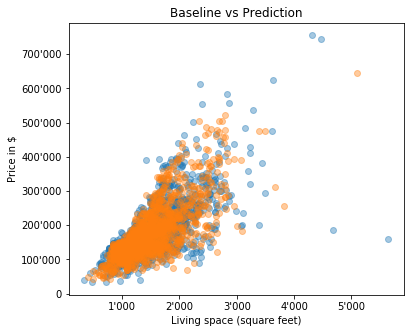

In [95]:
draw_sanity_check(y_predicted, in_dollars=False)

In [96]:
write_submission(y_predicted)

File written to C:\Source\predicting-house-prices\submissions\20180823163321.csv


Kaggle score: 0.13128